<a href="https://colab.research.google.com/github/thisspider/Tytus-HW/blob/main/6010570008159268_Wilam_8_Conversation_and_Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 8 - Conversation and Text Generation
Many natural language activities boil down to text generation, especially the back-and-forth nature of natural conversation and question answering. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

Much 2022 NLP research is on text generation. Most famously, this is the primary use of large language models like GPT-3 (OpenAI), Wu Dao (Beijing Academy of AI), and Gopher (DeepMind).

In [39]:
import seaborn as sns

In [6]:
!pip install transformers

In [77]:
import lucem_illud

/usr/local/lib/python3.7/dist-packages/spacy/util.py:841: UserWarning: [W094] Model 'en_core_web_sm' (2.2.5) specifies an under-constrained spaCy version requirement: >=2.2.2. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.2.3,<3.3.0
  warnings.warn(warn_msg)


OSError: ignored

In [76]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics
import pickle #if you want to save layouts
import os
import io

import networkx as nx

%matplotlib inline

import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, Randomtempr, Sequentialtempr
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # pip install tranformers==2.4.1
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-nxui4icz
  Running command git clone -q https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-nxui4icz


In [7]:
%matplotlib inline

In [8]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

# ConvoKit
As we alluded to in Week 6 with causal inference, [ConvoKit](https://convokit.cornell.edu/) is an exciting platform for conversational analysis developed by Jonathan Chang, Calem Chiam, and others, mostly at Cornell. Keep this in mind if you are interested in a final project with conversational data such as Twitter threads or movie scripts. They have an [interactive tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), which we include some examples from below. Most of the following text and code is authored by them.

These ConvoKit corpora can be used for the next exercise in this notebook.

In [9]:
try:  
    import convokit
except ModuleNotFoundError:
    !pip install convokit

     |████████████████████████████████| 167 kB 4.3 MB/s 
     |████████████████████████████████| 6.0 MB 52.7 MB/s 
     |████████████████████████████████| 1.5 MB 59.9 MB/s 
     |████████████████████████████████| 235 kB 55.5 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 175 kB 54.0 MB/s 
     |████████████████████████████████| 749 kB 43.8 MB/s 
     |████████████████████████████████| 181 kB 56.9 MB/s 
     |████████████████████████████████| 451 kB 69.0 MB/s 
     |████████████████████████████████| 653 kB 51.6 MB/s 
     |████████████████████████████████| 10.1 MB 31.6 MB/s 
     |████████████████████████████████| 42 kB 684 kB/s 
  Created wheel for convokit: filename=convokit-2.5.3-py3-none-any.whl size=204129 sha256=58ec5ace0813f8c96fb8f6022b5d7a51b5a55937608001f4ca48314d0f9834a2
  Stored in directory: /root/.cache/pip/wheels/b0/e8/2d/81c4477fe586fe4dad2de2886b990e90e839ffccd5158ed0f3
  Created wheel for emoji: filename=emoji-1.7.

In [10]:
# for pretty printing of cells within the Colab version of this notebook
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [11]:
import convokit
from convokit import Corpus, download

### Loading a Corpus

A Corpus represents a conversational dataset. We typically begin our analysis by loading a Corpus. A list of existing datasets already in ConvoKit format can be found [here](https://convokit.cornell.edu/documentation/datasets.html). 

A growing list of many other conversational datasets covering a variety of conversational settings are available in ConvoKit, such as face-to-face (e.g. the [*Intelligence Squared Debates corpus*](https://convokit.cornell.edu/documentation/iq2.html)), institutional (e.g. the [*Supreme Court Oral Arguments corpus*](https://convokit.cornell.edu/documentation/supreme.html)), fictional (e.g. the [*Cornell Movie Dialog Corpus*](https://convokit.cornell.edu/documentation/movie.html)), or online  (e.g. all talkpage conversations on [*Wikipedia Talk Pages*](https://convokit.cornell.edu/documentation/wiki.html) and a full dump of [*Reddit*](https://convokit.cornell.edu/documentation/subreddit.html)).

For this tutorial, we will primarily be using the *r/Cornell* subreddit corpus to demo various ConvoKit functionality, and occasionally the [*Switchboard Dialog Act Corpus*](https://convokit.cornell.edu/documentation/switchboard.html) (a collection of anonymized five-minute telephone conversations) as a contrasting dataset.

In [12]:
corpus = Corpus(download('subreddit-Cornell'))

# You can try a different corpus if you want.
#corpus = Corpus(download('diplomacy-corpus'))
#corpus = Corpus(download('switchboard-corpus'))
#corpus = Corpus(download('reddit-corpus-small'))

In [13]:
corpus.print_summary_stats()

Number of Speakers: 7568
Number of Utterances: 74467
Number of Conversations: 10744


### Corpus components: Conversations, Utterances, Speakers

Every Corpus has three main components: [Conversations](https://convokit.cornell.edu/documentation/conversation.html), [Utterances](https://convokit.cornell.edu/documentation/utterance.html), and [Speakers](https://convokit.cornell.edu/documentation/speaker.html). Just as in real life, in ConvoKit, Conversations are some sequence of Utterances, where each Utterance is made by some Speaker. Let's look at an example of each.

In [14]:
# This is a Reddit thread
corpus.random_conversation().meta

{'author_flair_text': '',
 'domain': 'self.Cornell',
 'gilded': 0,
 'gildings': None,
 'num_comments': 6,
 'stickied': False,
 'subreddit': 'Cornell',
 'timestamp': 1429242666,
 'title': 'Anyone have experience with Coops?'}

In [15]:
# This is a Reddit post or comment.
corpus.random_utterance().meta

{'author_flair_text': 'Information Science 2018',
 'gilded': 0,
 'gildings': None,
 'permalink': '',
 'retrieved_on': 1473273341,
 'score': 1,
 'stickied': False,
 'subreddit': 'Cornell',
 'top_level_comment': 'd65x24v'}

In [16]:
# The r/Cornell Corpus does not have speaker metadata.
#corpus.random_speaker().meta

#Speaker do have an 'id' which is their Reddit username, as seen here.
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7f81e8bf5c50>, 'id': 'goatbean'})

In [17]:
# We can iterate through these objects as we iterate lists or DataFrames in Python.
for utt in corpus.iter_utterances():
    print(utt.text)
    break 

I was just reading about the Princeton Mic-Check and it's getting [national press](http://www.bloomberg.com/news/2011-12-29/princeton-brews-trouble-for-us-1-percenters-commentary-by-michael-lewis.html).

I want to get a sense of what people felt like around campus. Anything interesting happen? Anything interesting coming up?


Conversations, Utterances, and Speakers are each interesting, but the magic of conversational analysis is connecting them. For example, we can get all the Conversations in which a Speaker has participated and all the Utterances they have made. To make it more interesting, we can find a Speaker to study by navigating from a random Utterance.

In [18]:
# consider this sequence of operations that highlight how to navigate between components
utt = corpus.random_utterance()
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
spkr = utt.speaker # get the Speaker who made the Utterance

spkr_convos = list(spkr.iter_conversations())

# Display up to 3 of their conversations.
spkr_convos[:3]

[Conversation({'obj_type': 'conversation', 'meta': {'title': 'course schedule planner for Cornell University', 'num_comments': 7, 'domain': 'self.Cornell', 'timestamp': 1325530635, 'subreddit': 'Cornell', 'gilded': -1, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f81e8bf5c50>, 'id': 'o0145'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'should we advertise ourselves on facebook?', 'num_comments': 9, 'domain': 'self.Cornell', 'timestamp': 1325620506, 'subreddit': 'Cornell', 'gilded': -1, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f81e8bf5c50>, 'id': 'o1gca'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'oh look.. a picture!', 'num_comments': 45, 'domain': 'self.Cornell', 'timestamp': 1325571377, 'subreddit': 'Cornell', 'gilded': -1, 'gildings': None, 'sti

For a more qualitative feel of the data, you can display a Conversation. For Reddit data, this is a single thread.

In [19]:
# We truncate sentences at character 80 to avoid making this notebook too long!
convo.print_conversation_structure(lambda utt: utt.text[:80] + "\n")

Accepted Early Decision! I can't wait to go, it has been my dream school for yea

    Me too!!!!!!!!! I'm so happy right now! Which college?

        CALS 

            Me too!!!!!! :D 

            Me too!!!!! :D

                wow that's awesome! I was literally in shock when I saw it. Major?

                    I was too! I even cried :P I was totally expecting rejection. And Veterinary Med

                        Atmospheric science. I cried too hahaha

                        It's a long walk to the AnSci Building from the freshman dorms. The farthest of 

                            Thanks for the tip!(:

                            Or make friends with someone who has a car.  One of the only places you can actu

                            You could also take the bus. All freshmen get free bus passes still, if I rememb

                                the bus drops off at a nearby building, but not right in front. the building is 

                                    You're 

There is a lot more to ConvoKit that we encourage you to explore, especially their [tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), but the ability to seamlessly navigate between the Utterances, Conversations, and Speakers of a Corpus is extremely valuable for social science.

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that use ConvoKit to analyze a Corpus other than 'subreddit-Cornell', including at least one function you find in the package not used above. You can also generate a ConvoKit Corpus from your own dataset based on [their Corpus from .txt files tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/converting_movie_corpus.ipynb) or [their Corpus from pandas tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/corpus_from_pandas.ipynb), but that may be time-consuming for a weekly assignment. (It could be a great idea for your final project!)

In [20]:
corpus = Corpus(download('subreddit-TrueFilm'))



In [21]:
corpus.print_summary_stats()

Number of Speakers: 40221
Number of Utterances: 368058
Number of Conversations: 21214


In [22]:
corpus.random_conversation().meta

{'author_flair_text': '',
 'domain': 'self.TrueFilm',
 'gilded': 0,
 'gildings': None,
 'num_comments': 47,
 'stickied': False,
 'subreddit': 'TrueFilm',
 'timestamp': 1480311061,
 'title': 'Video essay: "The Immersive Realism of Studio Ghibli"'}

In [23]:
corpus.random_utterance().meta

{'author_flair_text': '',
 'gilded': 0,
 'gildings': None,
 'permalink': '/r/TrueFilm/comments/85c5cr/what_have_you_been_watching_week_of_march_18_2018/dvwbfrs/',
 'retrieved_on': 1525302575,
 'score': 4,
 'stickied': False,
 'subreddit': 'TrueFilm',
 'top_level_comment': 'dvwbfrs'}

In [24]:
corpus.random_speaker().meta 

# I notice lack of speaker metadata

{}

In [25]:
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7f81eb6385d0>, 'id': 'filmistruth24'})

In [26]:

utt = corpus.random_utterance()
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
spkr = utt.speaker # get the Speaker who made the Utterance

spkr_convos = list(spkr.iter_conversations())

# Display up to 3 of their conversations.
spkr_convos[:3]

[Conversation({'obj_type': 'conversation', 'meta': {'title': 'Questions about Birdman [SPOILERS]', 'num_comments': 18, 'domain': 'self.TrueFilm', 'timestamp': 1419093098, 'subreddit': 'TrueFilm', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': 'Live! Die! Live Again!'}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f81eb6385d0>, 'id': '2pw7rp'})]

In [27]:
# I truncate sentences at character 100 to avoid making this notebook too long!
convo.print_conversation_structure(lambda utt: utt.text[:100] + "\n")

So anyway, me and my buddy saw *Birdman* last night and it was pretty freaking great. Easily one of 

    [deleted]

    [deleted]

    Birdman was super. *Ha!*

But seriously. Here's my take on the ending. Maybe it is. Maybe it isn't. 

    I agree with you that he killed himself on stage. The way I took the final scene was that he was in 

    Yeah! I had the same confusion, and my wife was unsatisfied with the ending (the flying away/ascensi

    I don't think that's the correct way to analyze the final scene precisely because of the deep conclu

        It should be noted, however, that Birdman says nothing to him in the final scene.  Throughout the en

            I'm pretty sure he mutters "fuck you."

                Does he?  Well, shit, that undermines my whole analysis.

                    Eh, I don't know if that really does... Riggan doesn't seem to pay attention to him, and it does see

                        That's a good point.  Also, he's on the toilet at the very end

In [28]:
spkr.get_utterances_dataframe().head()

,timestamp,text,speaker,reply_to,conversation_id,meta.author_flair_text,meta.gilded,meta.gildings,meta.permalink,meta.retrieved_on,meta.score,meta.stickied,meta.subreddit,meta.top_level_comment,vectors
id,,,,,,,,,,,,,,,
cn17xrz,1419159111,"He says something like ""Goodbye. And fuck you.""",TimeLordOfTheRings,cn10kdb,2pw7rp,,0,None,,1425289761,1,False,TrueFilm,cn0rlgx,[]


In [29]:
corpus.get_conversations_dataframe().head()

,vectors,meta.title,meta.num_comments,meta.domain,meta.timestamp,meta.subreddit,meta.gilded,meta.gildings,meta.stickied,meta.author_flair_text
id,,,,,,,,,,
1dibqs,[],Discussion: Shane Black as a director,9,self.TrueFilm,1367444389,TrueFilm,0,None,False,
1di8c1,[],Discussion of Quentin Tarantino's Direction,93,self.TrueFilm,1367441959,TrueFilm,0,None,False,
1di312,[],Odd occurences and motifs in An American Werew...,6,self.TrueFilm,1367438104,TrueFilm,0,None,False,
1dhl0a,[],Twilight vs Harry Potter: Why the massive cont...,9,self.TrueFilm,1367424734,TrueFilm,0,None,False,
1dhcmy,[],"Let's talk about Ben Affleck, the director",115,self.TrueFilm,1367417763,TrueFilm,0,None,False,


In [30]:
convo.print_conversation_structure()

DoNotMatter
    [deleted]
    [deleted]
    LiteraryBoner
    samwisegamtree9
    artearth
    Thebullshitman
        Sadsharks
            dfekt
                Sadsharks
                    dfekt
                        Sadsharks
                TimeLordOfTheRings
    ohzno
    Rice_Dream_Girl
        neatknobcreek
    Armchair_Marxist
        cooljpeg
            Armchair_Marxist


# Interactional influence

Before we utilize transformers, let's see how to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network based on a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdata/1411.2674.pdata). This relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [ ]:
result_path = '/content/drive/MyDrive/data/Bayesian-echo/results/{}/'.format(example_name)
#if not os.path.isdir(result_path):
#    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [ ]:
data_meta_info = pd.read_table(result_path + 'meta-info.txt',header=None)
data_log_prob = pd.read_csv(result_path + "temp-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob temps
data_influence = pd.read_csv(result_path + 'temp-influence.txt',delim_whitespace=True) # influence temps
data_participants = pd.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pd.Series(data_participants['agent.num'].values-1,index=data_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Foreman': 3,
 'Juror 10': 2,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 2': 9,
 'Juror 3': 1,
 'Juror 4': 5,
 'Juror 5': 11,
 'Juror 6': 8,
 'Juror 7': 4,
 'Juror 8': 0,
 'Juror 9': 10}

In [ ]:
data_influence

,influence.1.1,influence.1.2,influence.1.3,influence.1.4,influence.1.5,influence.1.6,influence.1.7,influence.1.8,influence.1.9,influence.1.10,influence.1.11,influence.1.12,influence.2.1,influence.2.2,influence.2.3,influence.2.4,influence.2.5,influence.2.6,influence.2.7,influence.2.8,influence.2.9,influence.2.10,influence.2.11,influence.2.12,influence.3.1,influence.3.2,influence.3.3,influence.3.4,influence.3.5,influence.3.6,influence.3.7,influence.3.8,influence.3.9,influence.3.10,influence.3.11,influence.3.12,influence.4.1,influence.4.2,influence.4.3,influence.4.4,...,influence.9.9,influence.9.10,influence.9.11,influence.9.12,influence.10.1,influence.10.2,influence.10.3,influence.10.4,influence.10.5,influence.10.6,influence.10.7,influence.10.8,influence.10.9,influence.10.10,influence.10.11,influence.10.12,influence.11.1,influence.11.2,influence.11.3,influence.11.4,influence.11.5,influence.11.6,influence.11.7,influence.11.8,influence.11.9,influence.11.10,influence.11.11,influence.11.12,influence.12.1,influence.12.2,influence.12.3,influence.12.4,influence.12.5,influence.12.6,influence.12.7,influence.12.8,influence.12.9,influence.12.10,influence.12.11,influence.12.12
0,0.0,7.240730,4.702604,2.539944e-03,4.915878,0.234594,2.887878e-02,3.646830e-08,9.490003,6.356666e-08,4.789321,6.655245,9.685236,0.0,9.652234,0.001774,2.593849e+00,2.879051,0.003033,0.000132,3.966711,8.527078,1.476417e-03,3.831109,8.451638,8.348058,0.0,4.732651,4.863475,0.000223,0.000295,3.837242e-02,4.918744,0.000119,0.000154,2.074550,0.000982,0.002634,4.550601,0.0,...,0.0,2.446853,3.967187,0.051861,7.796441e-02,0.000148,3.442172e-01,1.205272e-08,0.434625,0.289884,0.021088,0.004127,3.354044,0.0,8.583332,1.517640e+00,0.078951,8.943808,0.012397,1.931913e+00,1.190800e-07,2.305450,3.506208e-27,0.005451,0.012671,0.108633,0.0,1.785300e-01,9.355893e-16,0.001140,6.330250e-06,1.020156e-08,7.232644e-04,1.440486e-06,0.000017,0.063089,2.801879e-06,2.842628e-02,3.513195,0.0
1,0.0,3.103347,5.093965,5.242095e-03,3.969870,1.031339,7.949459e-02,6.906917e-08,6.022482,6.239338e-08,9.660538,1.079112,9.669401,0.0,7.358566,0.007430,3.047027e+00,7.829095,0.001017,0.000455,2.724052,1.441817,4.370695e-04,2.087002,8.701610,7.677400,0.0,2.212903,9.579650,0.001136,0.002977,2.390734e-02,3.948491,0.000035,0.000087,1.559877,0.217879,0.000609,6.011882,0.0,...,0.0,9.864544,0.086581,0.021513,5.571332e-01,0.000105,7.743107e-02,3.283050e-08,0.108718,6.105083,0.024702,0.013823,1.468741,0.0,8.594581,7.488646e+00,0.178052,8.660844,0.012468,3.602183e-01,3.841687e-07,3.130658,1.648679e-26,0.004107,0.024229,0.018018,0.0,2.039678e-01,2.455287e-15,0.002150,1.299228e-05,4.460212e-09,1.495242e-02,2.372059e-06,0.000414,0.017970,2.732697e-06,3.181891e-02,7.722436,0.0
2,0.0,3.361763,4.313076,7.637620e-03,4.088690,2.545821,1.275696e+00,1.059713e-08,6.956479,1.965166e-08,5.574526,4.871411,8.006858,0.0,8.125650,0.004644,2.243273e-01,9.029547,0.001420,0.022150,4.160230,2.819143,2.860486e-04,1.497060,9.443378,8.197135,0.0,2.141343,5.777104,0.000635,0.000623,2.885265e-02,2.362772,0.000020,0.000750,2.403635,0.388678,0.000902,3.962249,0.0,...,0.0,7.778443,0.022048,0.331547,6.959539e-01,0.000320,6.845500e-02,7.010671e-09,0.139857,4.001331,0.036569,0.001604,5.524442,0.0,9.104705,8.951971e+00,0.191832,6.884624,0.053049,1.141810e+00,5.251910e-06,5.446748,3.950951e-26,0.004644,0.015751,0.239795,0.0,2.409094e+00,1.013238e-14,0.001348,4.875007e-07,9.515534e-10,1.382057e-02,2.357237e-06,0.002246,0.013095,2.854606e-06,5.942173e-03,5.626257,0.0
3,0.0,6.789371,9.210530,1.229763e-02,8.676811,2.863489,3.968520e-02,9.745022e-08,7.079359,7.228776e-09,6.606718,6.273822,9.554149,0.0,9.434289,0.005189,3.509801e-01,6.631807,0.000217,0.024976,4.738844,3.784410,1.477047e-05,1.504738,7.611166,9.256431,0.0,9.714995,6.307594,0.001429,0.000822,1.024489e-03,3.538300,0.000008,0.000416,1.830426,1.360395,0.000352,3.399184,0.0,...,0.0,7.102754,0.062906,0.718744,8.443908e-01,0.000858,2.932160e-01,6.634396e-09,0.424775,6.541088,0.064110,0.002000,4.37050

In [ ]:
def getDensity(data):
    data = data#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

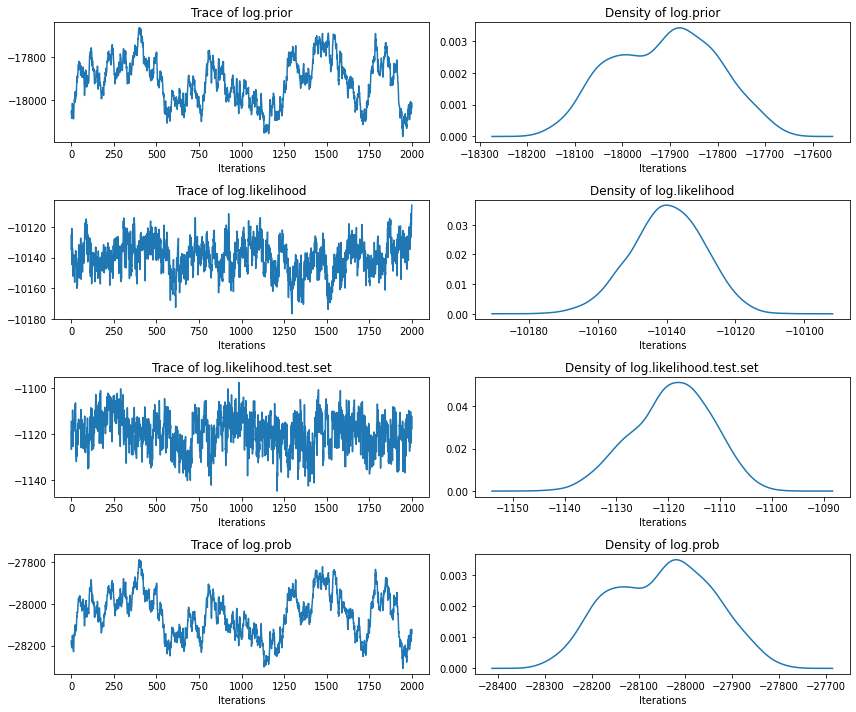

In [ ]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(data_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(data_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(data_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(data_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(data_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(data_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(data_log_prob['log.prior']+data_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(data_log_prob['log.prior']+data_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [ ]:
A = int(np.sqrt(len(data_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [ ]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    data_ = pd.DataFrame(influence_matrix) 
    
    data_ =data_.rename(index = id_person)
    data_ =data_.rename(columns = id_person)
    return data_

In [ ]:
stacked = data_influence.mean(axis=0)
data_mean = getmatrix(stacked,A)

stacked = data_influence.std(axis=0)
data_std = getmatrix(stacked,A)

In [ ]:
data_mean

,Juror 8,Juror 3,Juror 10,Foreman,Juror 7,Juror 4,Juror 11,Juror 12,Juror 6,Juror 2,Juror 9,Juror 5
Juror 8,0.000000,3.757957,8.089079,0.930180,5.167497,0.794645,0.845335,1.336329,6.106684,0.916765,6.385205,7.300776
Juror 3,8.529312,0.000000,6.673916,4.150076,2.534751,4.902852,1.092571,0.509942,3.825015,3.861767,0.266426,1.561626
Juror 10,8.413188,7.427932,0.000000,4.540236,3.216307,1.030049,1.004598,0.529232,2.426582,0.407460,1.233599,0.885871
Foreman,1.137060,0.612615,1.945196,0.000000,1.521390,0.834870,1.338554,3.230634,1.013511,3.534036,1.311436,4.115411
Juror 7,2.603853,5.901169,0.648844,1.969868,0.000000,1.110101,0.279870,0.608548,1.047693,2.910670,1.619475,1.570038
Juror 4,5.791320,0.200669,0.266484,0.582956,0.094200,0.000000,3.347982,0.316963,0.300770,2.112033,0.370973,0.673364
Juror 11,0.378515,0.544628,0.779340,0.454645,0.290575,0.447512,0.000000,0.614536,0.821143,0.951222,0.476986,0.844157
Juror 12,5.961338,0.695831,0.519459,1.253033,0.247939,0.162463,0.388620,0.000000,2.500976,2.375977,0.481394,0.834032
Juror 6,4.526244,0.923784,0.503503,1.049825,1.288920,0.451562,0.375776,0.904313,0.000000,2.861587,0.905421,0.310822
Juror 2,0.583732,2.303417,0.529583,1.722894,2.005939,0.299311,0.652302,1.623813,0.841376,0.000000,1.691612,1.756225


MEAN of influence matrix (row=from, col=to)


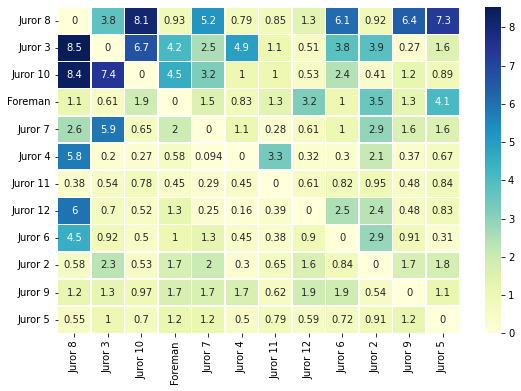

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(data_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


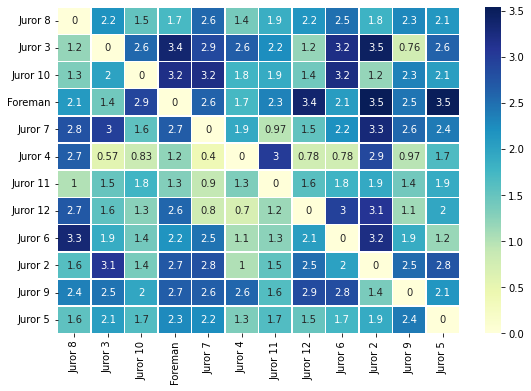

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(data_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [ ]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = data_influence[data_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = data_influence[data_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = data_mean.sum(axis=1) #mean of total influence sent
recieved =data_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


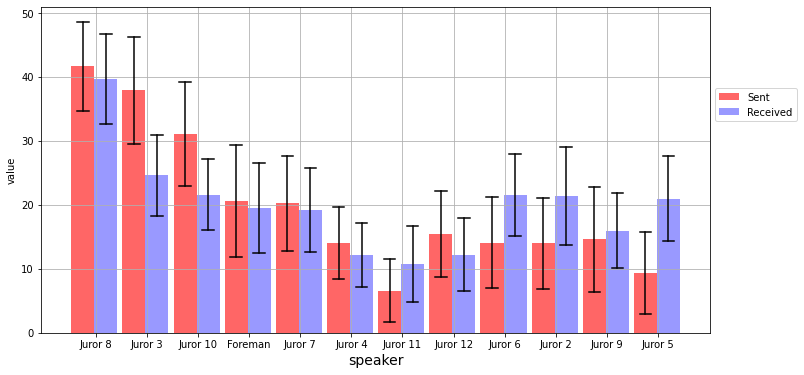

In [ ]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [ ]:
def drawNetwork(data,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in data.index:
        for to_ in data.columns:
            G.add_edge(from_,to_,weight = data.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [ ]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = data_influence.quantile(0.25)
data_q25 = getmatrix(stacked,A)

stacked = data_influence.quantile(0.5)
data_q50 = getmatrix(stacked,A)

stacked = data_influence.quantile(0.75)
data_q75 = getmatrix(stacked,A)

Mean Influence Network


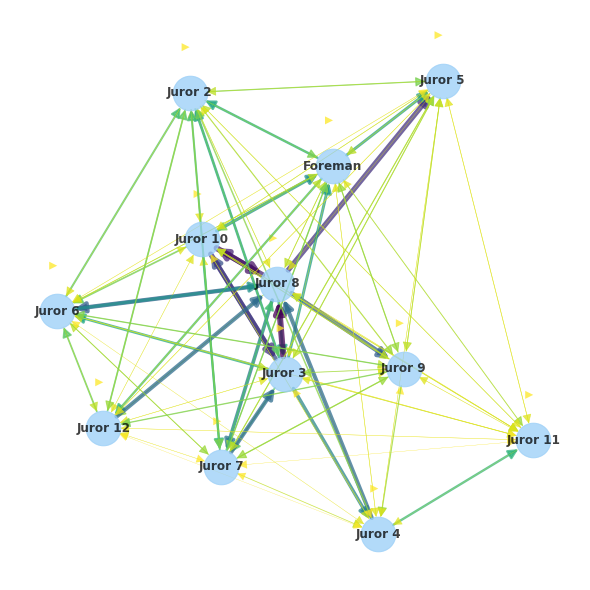

In [ ]:
G_mean = drawNetwork(data_mean,'Mean Influence Network')

25 Quantile Influence Network


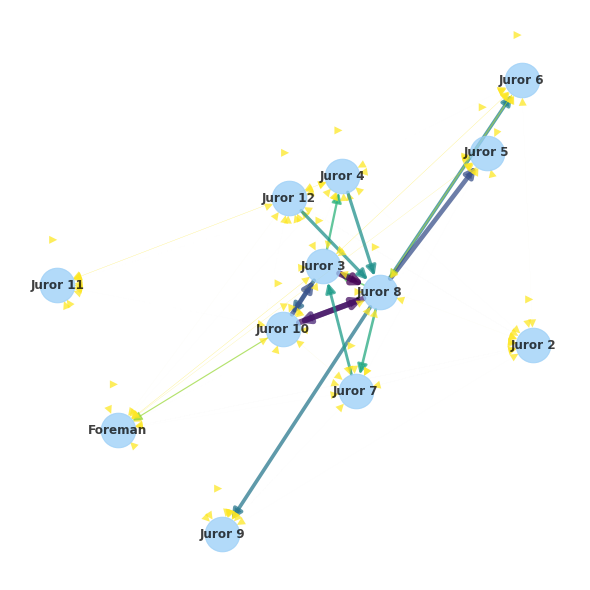

In [ ]:
G_q25 = drawNetwork(data_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


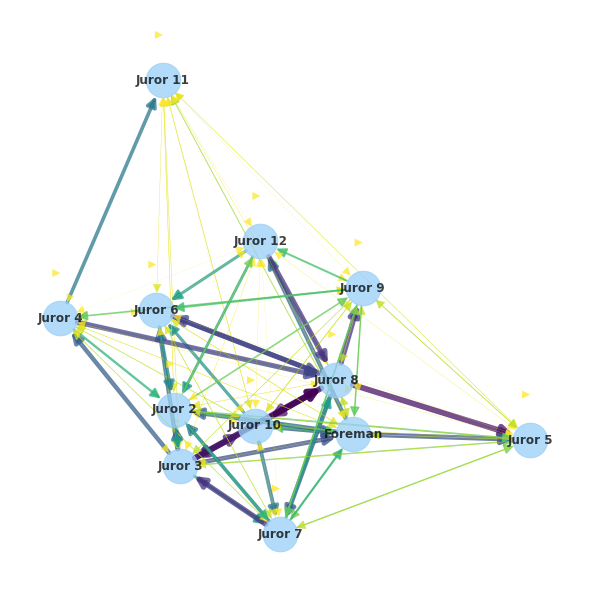

In [ ]:
G_q75 = drawNetwork(data_q75,'75 Quantile Influence Network')

In [ ]:
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [ ]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

data_transcript = pd.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
data_transcript[:2]

,name,tokens,start,end
0,Obama,"[sssj, jbca, fgbb, jbbb, lbsa, dfds, sicf, kbg...",0.082034,1.734327
1,Roosevelt,"[lhfs, acca, cgdj, lchd, alis, jlfj, lbal, acb...",2.334555,3.980675


Transform data into TalkbankXML format:

In [ ]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(data_transcript, output_fname, language = language )

New File saved to ./data/USpresident/USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [ ]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project (__or one from ConvoKit__). Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<font color="red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<font color="red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

In [55]:
corpus = Corpus(filename=download("diplomacy-corpus"))

data = corpus.get_utterances_dataframe()

# first 7000
temp = data[:7000]

temp.tail()

Dataset already exists at /root/.convokit/downloads/diplomacy-corpus


,timestamp,text,speaker,reply_to,conversation_id,meta.speaker_intention,meta.receiver_perception,meta.receiver,meta.absolute_message_index,meta.relative_message_index,meta.year,meta.game_score,meta.game_score_delta,meta.deception_quadrant,vectors
id,,,,,,,,,,,,,,,
Game2-austria-italy-478,2211,*TALK it out,italy-Game2,Game2-austria-italy-477,Game2-austria-italy,Truth,Truth,austria-Game2,2211,478,1905,6,-2,Straightforward,[]
Game2-austria-italy-479,2213,I don't blame you. I don't think the build was...,austria-Game2,Game2-austria-italy-478,Game2-austria-italy,Truth,Truth,italy-Game2,2213,479,1905,8,2,Straightforward,[]
Game2-austria-italy-480,2214,The main point is that Germany is terrifying a...,austria-Game2,Game2-austria-italy-479,Game2-austria-italy,Truth,Truth,italy-Game2,2214,480,1905,8,2,Straightforward,[]
Game2-austria-italy-481,2221,Agreed re: Germany. Wish we’d had more time t...,italy-Game2,Game2-austria-italy-480,Game2-austria-italy,Truth,Truth,austria-Game2,2221,481,1905,6,-2,Straightforward,[]
Game2-austria-italy-482,2222,What have your interactions with england been ...,italy-Game2,Game2-austria-italy-481,Game2-austria-italy,Truth,Truth,austria-Game2,2222,482,1905,6,-2,Straightforward,[]


In [56]:
net = nx.Graph()

In [57]:
temp['speaker'].value_counts()

england-Game1     743
italy-Game1       683
germany-Game1     548
italy-Game2       472
russia-Game12     429
austria-Game11    341
france-Game1      313
turkey-Game12     311
germany-Game11    305
italy-Game11      292
turkey-Game11     265
france-Game12     264
austria-Game2     247
austria-Game10    236
germany-Game2     221
germany-Game10    190
russia-Game1      156
austria-Game1     148
england-Game10    148
france-Game11     124
russia-Game10     108
england-Game12     92
italy-Game10       83
france-Game10      52
italy-Game12       48
england-Game11     47
russia-Game11      42
turkey-Game1       27
austria-Game12     26
germany-Game12     25
turkey-Game10      14
Name: speaker, dtype: int64

In [58]:
for speaker in temp.speaker.unique():
  net.add_node(speaker)

In [59]:
for i, row in temp.iterrows():
  speaker = row['speaker']
  receiver = row['meta.receiver']
  if receiver in net.nodes():
    if (speaker, receiver) not in net.edges():
      net.add_edge(speaker, receiver, weight=0)
    if (speaker, receiver) in net.edges():
      net.edges[(speaker, receiver)]['weight'] += 1

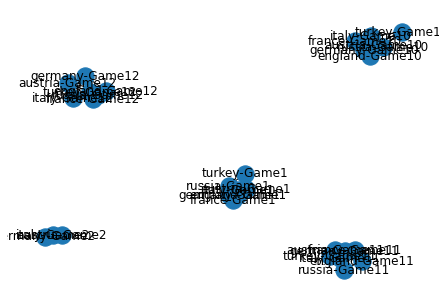

In [60]:


nx.draw(net, with_labels=True)

In [61]:
# we see mostly within-game ties

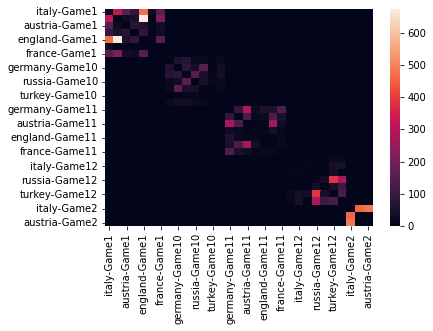

In [62]:
List = []
for node in net.nodes():
    lst = []
    for node_ in net.nodes():
        if node == node_ or (node, node_ ) not in net.edges:
            lst.append(0)
        else:
            lst.append(net.edges[(node, node_)]['weight'])
    List.append(lst)
M_ = np.array(List)
fig = plt.figure()
div = pd.DataFrame(M_, columns = list(net.nodes()), index = list(net.nodes()))
ax = sns.heatmap(div)
plt.show()

In [63]:
from networkx.algorithms.community import greedy_modularity_communities
communitieS = list(greedy_modularity_communities(net))

In [64]:
communitieS

[frozenset({'austria-Game1',
            'england-Game1',
            'france-Game1',
            'germany-Game1',
            'italy-Game1',
            'russia-Game1',
            'turkey-Game1'}),
 frozenset({'austria-Game10',
            'england-Game10',
            'france-Game10',
            'germany-Game10',
            'italy-Game10',
            'russia-Game10',
            'turkey-Game10'}),
 frozenset({'austria-Game11',
            'england-Game11',
            'france-Game11',
            'germany-Game11',
            'italy-Game11',
            'russia-Game11',
            'turkey-Game11'}),
 frozenset({'austria-Game12',
            'england-Game12',
            'france-Game12',
            'germany-Game12',
            'italy-Game12',
            'russia-Game12',
            'turkey-Game12'}),
 frozenset({'austria-Game2', 'germany-Game2', 'italy-Game2'})]

In [65]:
degreecentrality = nx.degree_centrality(net)

In [66]:
temp['meta.game_score'] = temp['meta.game_score'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
dic = temp.groupby('speaker')['meta.game_score'].mean()

In [68]:

centrals = []
scores = []
for speaker in net.nodes():
  centrals.append(degreecentrality[speaker])
  scores.append(dic[speaker])

In [69]:
centrality = pd.DataFrame({'scores': scores,
                               'centrality': centrals, 
                               }, index=net.nodes())

In [70]:
centrality.head()

,game_scores,centrality
italy-Game1,7.666179,0.200000
germany-Game1,5.534672,0.166667
austria-Game1,4.750000,0.200000
russia-Game1,5.339744,0.200000
england-Game1,4.830417,0.200000


In [71]:
centrality['centrality']

italy-Game1       0.200000
germany-Game1     0.166667
austria-Game1     0.200000
russia-Game1      0.200000
england-Game1     0.200000
turkey-Game1      0.166667
france-Game1      0.200000
italy-Game10      0.200000
germany-Game10    0.200000
austria-Game10    0.200000
russia-Game10     0.200000
england-Game10    0.200000
turkey-Game10     0.166667
france-Game10     0.166667
germany-Game11    0.200000
italy-Game11      0.200000
austria-Game11    0.200000
russia-Game11     0.200000
england-Game11    0.166667
turkey-Game11     0.166667
france-Game11     0.200000
germany-Game12    0.200000
italy-Game12      0.200000
austria-Game12    0.200000
russia-Game12     0.200000
england-Game12    0.200000
turkey-Game12     0.200000
france-Game12     0.200000
italy-Game2       0.066667
germany-Game2     0.033333
austria-Game2     0.033333
Name: centrality, dtype: float64

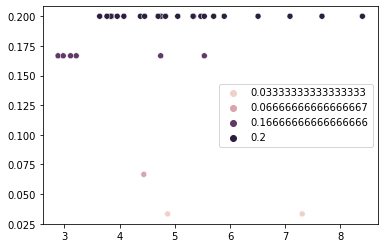

In [72]:
sns.scatterplot(x=scores, y=centrals, hue=centrals);

In [ ]:
# if your game scores are high, players speak with you more frequently 

In [78]:
temp.iloc[1, :]['text']

"You've whet my appetite, Italy. What's the suggestion?"

## Text Generation using GPT-2 and BERT

We can make use of the transformers we learned about last week to do text generation, where the model takes one or multiple places in a conversation. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

We will be using the built in generate function, but the example file has more detailed code which allows you to set the seed differently.

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [ ]:
sequence = "Nothing that we like to do more than party"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=200)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nothing that we like to do more than party with the people. We're not going to do it for the money. We're going to do it for the people."

The party's campaign manager, Robby Mook, said the party's goal was to "make sure that the people of the state of New York are not left out of the political process."

"We're not going to be a party of the rich and powerful," he said. "We're not going to be a party of the working class and working families. We're not going to be a party of the working class and working families."

The party's campaign manager, Robby Mook, said the party's goal was to "make sure that the people of the state of New York are not left out of the political process."

"We're not going to be a party of the rich and powerful," he said. "We're not going to be a party of the


Wow. A little creepy, and as we can see, far from perfect: GPT doesn't alwats work out flawlessly, but it sometimes can, and we will try and see if fine-tuning helps. We are going to tune the model on a complete dataset of Trump tweets, as they have a set of distinctive, highly identifiable qualities.

### Creating a domain-specific language model

One of the most exciting things about BERT and GPT is being able to retune them the way we want to. We will be training models to perform two tasks - one is to create a BERT with an "accent", by traning a model with english news data from the UK, from the US, and from India. We will also train a language generation model with a bunch of Trump tweets. 

We can train models specifically over a certain domain to make its language generation similar to that domain. 
[run_language modelling.py](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py), followed by [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py). I've downloaded these files and added them to this directory so we can run them through the notebook. You are encouraged to look at these files to get a rough idea of what is going on.

### Loading Data 

We want to now get our Trump tweets and our English news datasets ready. The data the scripts expect is just a text file with relevant data. We load the Trump tweets and then write them to disk as train and test files with only data. I leave the original dataframes in case you would like to use it for your own purposes.

In [ ]:
datas = []

In [ ]:
for file in os.listdir("/content/drive/MyDrive/data/trump_tweets"):
    datas.append(pd.read_json("/content/drive/MyDrive/data/trump_tweets/" + file))

In [ ]:
data = pd.concat(datas)

In [ ]:
data.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
0,Twitter for iPhone,1079888205351145472,HAPPY NEW YEAR! https://t.co/bHoPDPQ7G6,2018-12-31 23:53:06+00:00,33548,NaN,136012,False
1,Twitter for iPhone,1079830268708556800,"....Senator Schumer, more than a year longer t...",2018-12-31 20:02:52+00:00,17456,25073877.0,65069,False
2,Twitter for iPhone,1079830267274108928,Heads of countries are calling wanting to know...,2018-12-31 20:02:52+00:00,21030,NaN,76721,False
3,Twitter for iPhone,1079763923845419008,It’s incredible how Democrats can all use thei...,2018-12-31 15:39:15+00:00,29610,NaN,127485,False
4,Twitter for iPhone,1079763419908243456,"I’m in the Oval Office. Democrats, come back f...",2018-12-31 15:37:14+00:00,30957,NaN,132439,False


In [ ]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(data['text'], test_size=0.2)

In [ ]:
train_text.head()

6993    "@erikmthompson: I just don't want #DonaldTrum...
1540    Jeb, why did your brother attack and destabali...
3005    Watching other networks and local news. Really...
5681    "@PRINCEOMEGA                 \n@ZagatChicago ...
2219    RT @JesseBWatters: Will be 🔥@TPUSA https://t.c...
Name: text, dtype: object

In [ ]:
train_text.to_frame().to_csv(r'train_text_trump', header=None, index=None, sep=' ', mode='a')

In [ ]:
test_text.to_frame().to_csv(r'test_text_trump', header=None, index=None, sep=' ', mode='a')

I now used the Google Colab GPUs to train the Trump tweet models. We'll be doing the same for our blog posts too.

### GloWBe dataset

We'll now load up the GloWbe (Corpus of Global Web-Based English) dataset which have different texts from different countries. We'll try and draw out texts from only the US, UK and India. We'll then save these to disk. Note that this is a Davies Corpora dataset: the full download can be done with the Dropbox link I sent in an announcement a few weeks ago. The whole download is about 3.5 GB but we only need two files, which are anout 250 MB each. The other files might be useful for your research purposes.

In [ ]:
address = "C:/Downloads/GloWbE"

In [ ]:
# these are the exact name of the files
us = "/text_us_blog_jfy.zip"
gb = "/text_gb_blog_akq.zip"

In [ ]:
us_texts = lucem_illud.loadDavies(address, corpus_style="us_blog", num_files=5000)

FileNotFoundError: ignored

In [ ]:
gb_texts = lucem_illud.loadDavies(address, corpus_style="gb_blog", num_files=5000)

We now have a dictionary with document ids mapping to text. Since we don't need any information but the text, we can just save these to disk.

In [ ]:
' '.join(list(us_texts.values())[10])

In [ ]:
def dict_to_texts(texts, file_name):
    text = []
    for doc in list(texts.values()):
        text.append(' '.join(doc).replace("< h >", "").replace("< p >", ""))
    train_text, test_text = train_test_split(text, test_size=0.2)
    with open(file_name + "_train", 'w') as f:
        for item in train_text:
            f.write("%s\n" % item)
    
    with open(file_name + "_test", 'w') as f:
        for item in test_text:
            f.write("%s\n" % item)

In [ ]:
dict_to_texts(us_texts, "us_blog")

In [ ]:
dict_to_texts(gb_texts, "gb_blog")

We now have the training and testing files for both US and GB blogs in English. 

(WARNING - SHIFT TO GOOGLE COLAB OR GPU ENABLED MACHINE)


### Running Scripts

We use the scripts to do language modelling and text generation. The following cells run the code as if you would have run it in a terminal. I trained all of these models using the Googlr Colab file, and then saved the models to disk.

#### Trump GPT-2

In [ ]:
!python run_language_modelling.py --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump

#### RoBERTa US

In [ ]:
!python run_language_modeling.py --output_dir=output_roberta_US --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=$TRAIN_FILE --do_eval --eval_data_file=$TEST_FILE --mlm

#### RoBERTa UK

In [ ]:
!python run_language_modeling.py --output_dir=output_roberta_UK --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=$TRAIN_FILE --do_eval --eval_data_file=$TEST_FILE --mlm

(If you left to use a GPU machine, COME BACK TO THIS NOTEBOOK to load and work with your trained model.)

### Loading and using models

Let us now load the four models we have and see how we can use them.

And now - let us see what our Trump Tweet Bot looks like!
You can generate text via command line using the command below. You can also load a model once it is saved - I trained my model using Google Colab, downloaded the model, and am loading it again via the command below. Note that you have to download all the files in your folder of the fine-tuned model to use the model.

In [ ]:
#!python run_generation.py --model_type=gpt2 --model_name_or_path=output_trump_gpt

#!python run_generation.py --model_type=gpt2 --model_name_or_path=/content/giving_pledge_gpt/gpt2_cached_lm_1024_train_text_trump


In [ ]:
tokenizer_trump = AutoTokenizer.from_pretrained("gpt2_cached_lm_1024_train_text_trump")
model_trump = AutoModelWithLMHead.from_pretrained("gpt2_cached_lm_1024_train_text_trump")

In [ ]:
sequence = "Obama is going to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Wow - our Trump bot is nasty, so we know our model trained well. What happens if we try the same sentence for our non-fine tuned model?

In [ ]:
sequence = "Obama is going to"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Quite the contrast.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

In [ ]:
import pandas
path = '/content/drive/MyDrive/letters_and_metadata.csv'
data = pandas.read_csv(path, index_col=0)
data = data[(~data["letters_text"].isna())]
holdBackFraction = .2
train_data_data, test_data_data = sklearn.model_selection.train_test_split(data, test_size=holdBackFraction)



In [ ]:
train_text = train_data_data["letters_text"]
test_text = test_data_data["letters_text"]

In [ ]:
train_text

135    “I am committed to the belief that we would al...
186    “We believe in the importance of investing in ...
108    “We don't want to be the richest guys in the g...
86     "Not only are we pledging to spend the great m...
189    "I cannot think of a more personally rewarding...
                             ...                        
209    "I don't think there's another group like it a...
0      "Humanity has a limited amount of time to turn...
196    "Although it has been our privilege to be able...
61     "Not only are we pledging to spend the great m...
168    “Now, as I approach my 70th birthday, I am mor...
Name: letters_text, Length: 162, dtype: object

In [ ]:
train_text.to_frame().to_csv(r'train_text_trump', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_text_trump', header=None, index=None, sep=' ', mode='a')

In [ ]:

!python run_language_modelling.py --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump

python3: can't open file 'run_language_modelling.py': [Errno 2] No such file or directory


In [ ]:
import transformers

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:807: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [ ]:
pwd

'/content'

In [ ]:
cd /content/drive/MyDrive/output_gpt_trump

[Errno 2] No such file or directory: '/content/drive/MyDrive/output_trump_gpt'
/content


In [ ]:
#!python run_generation.py --model_type=gpt2 --model_name_or_path=output_trump_gpt

#!python run_generation.py --model_type=gpt2 --model_name_or_path=/content/giving_pledge_gpt/gpt2_cached_lm_1024_train_text_trump



tokenizer_trump = tokenizer_gpt
model_trump = AutoModelWithLMHead.from_pretrained("/content/drive/MyDrive/output_gpt_givingpledge")

sequence = "It is my great pleasure to provide this Giving Pledge commitment wherein I pledge to give at least 50% of my wealth to charitable causes both during my present life and beyond"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)



Most important issue is that the government has not been able to provide adequate funding for the program. The government has not been able to provide adequate funding for the program. The government has not been able to provide adequate funding for the program.

The


In [ ]:
#1a
sequence = "It is my great pleasure to provide this Giving Pledge commitment wherein I pledge to give at least 50% of my wealth to charitable causes both during my present life and beyond"


It is my great pleasure to provide this Giving Pledge commitment wherein I pledge to give at least 50% of my wealth to charitable causes both during my present life and beyond. I am grateful to my family and friends for their support and encouragement. I am also grateful to my wife, who has been a great inspiration to me and to my family. I am also grateful to my children, who have been blessed with the opportunity to pursue their dreams and pursue their dreams. I am also grateful to my wife, who has been a great inspiration to me and to my family. I am also grateful to my wife, who has been a great inspiration to me and to my family. I am also grateful to my wife, who has been a great inspiration to me and to my family. I am also grateful to my wife, who has been a great inspiration to me and to my family. I am also grateful to my wife, who has been a great inspiration to me and to my family. I am also grateful to my wife, who has been a great inspiration to me and to my family. I am 

In [ ]:
#1b
sequence = "It is my great pleasure to provide this Giving Pledge commitment wherein I pledge to give at least 50% of my wealth to charitable causes both during my present life and beyond"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

It is my great pleasure to provide this Giving Pledge commitment wherein I pledge to give at least 50% of my wealth to charitable causes both during my present life and beyond. I will also pledge to donate at least $100,000 to the National Endowment for the Arts, the National Endowment for the Humanities, and the National Endowment for the Arts. I will also pledge to donate at least $100,000 to the National Endowment for the Arts, the National Endowment for the Humanities, and the National Endowment for the Arts. I will also pledge to donate at least $100,000 to the National Endowment for the Arts, the National Endowment for the Humanities, and the National Endowment for the Arts. I will also pledge to donate at least $100,000 to the National Endowment for the Arts, the National Endowment for the Humanities, and the National Endowment for the Arts. I will also pledge to donate at least $100,000 to the National Endowment for the Arts, the National Endowment for the Humanities, and the N

In [ ]:
sequence = "My wealth comes "

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

My wealth comes  from my family, and I have a lot of money to spend. I have a lot of friends who are very wealthy, and I have a lot of money to spend. I have a lot of friends who are very poor, and I have a lot of money to spend. I have a lot of friends who are very wealthy, and I have a lot of money to spend. I have a lot of friends who are very poor, and I have a lot of money to spend. I have a lot of friends who are very poor, and I have a lot of money to spend. I have a lot of friends who are very poor, and I have a lot of money to spend. I have a lot of friends who are very poor, and I have a lot of money to spend. I have a lot of friends who are very poor, and I have a lot of money to spend. I have a lot of friends who are very poor, and I have a lot of money to spend. I have a lot of friends who are very poor, and I have a lot of money to spend. I have a lot of friends who are very poor, and I have a lot of money to spend. I have a lot of friends who are very poor, and I have a 

In [ ]:
sequence = "My wealth comes"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

My wealth comes from my family, and I have a lot of money to spend. I have a lot of money to spend on my children. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I have a lot of money to spend on my grandchildren. I

In [ ]:
sequence = "In five years I will"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

In five years I will be able to do this. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family and friends. I will be able to do this with my family 

In [ ]:
sequence = "I have an obligation to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

I have an obligation to protect the rights of the people of the United States and to protect the interests of the United States in the world. I have also been a member of the United Nations Security Council, and I have been a member of the United Nations Commission on Human Rights. I have been a member of the United Nations Commission on the Status of Women, and I have been a member of the United Nations Commission on the Status of Women. I have been a member of the United Nations Commission on the Status of Women. I have been a member of the United Nations Commission on the Status of Women. I have been a member of the United Nations Commission on the Status of Women. I have been a member of the United Nations Commission on the Status of Women. I have been a member of the United Nations Commission on the Status of Women. I have been a member of the United Nations Commission on the Status of Women. I have been a member of the United Nations Commission on the Status of Women. I have been

In [ ]:
sequence = "I have a lot"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

I have a lot of respect for the people who have been involved in this project. I am very proud of the work that has been done by the people who have been involved in this project. I am also very proud of the fact that I am able to share my experience with others who have been involved in this project. I am also very proud of the fact that I am able to share my experience with others who have been involved in this project. I am also very proud of the fact that I am able to share my experience with others who have been involved in this project. I am also very proud of the fact that I am able to share my experience with others who have been involved in this project. I am also very proud of the fact that I am able to share my experience with others who have been involved in this project. I am also very proud of the fact that I am able to share my experience with others who have been involved in this project. I am also very proud of the fact that I am able to share my experience with others

In [ ]:
sequence = "I have debt to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

I have debt to pay, and I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not going to be able to afford it. I have to make sure I'm not goin

In [ ]:
sequence = "Before I die I"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Before I die I will be reborn as a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a human being.

I am a

In [ ]:
# 5b

sequence = "Give to"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Give to the people of the United States of America, and to the people of the world, that we will not allow the United States to be a slave to any foreign power, and that we will not allow any foreign power to be a slave to any American.

And I will not allow any foreign power to be a slave to any American.

And I will not allow any foreign power to be a slave to any American.

And I will not allow any foreign power to be a slave to any American.

And I will not allow any foreign power to be a slave to any American.

And I will not allow any foreign power to be a slave to any American.

And I will not allow any foreign power to be a slave to any American.

And I will not allow any foreign power to be a slave to any American.

And I will not allow any foreign power to be a slave to any American.

And I will not allow any foreign power to be a slave to any American.

And I will not allow any foreign power to be a slave to any American.

And I will not allow any foreign power to be a slave

In [ ]:
sequence = "I want to give to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

I want to give to you a special thank you to the many people who have helped me with my writing and the work I have done. I am honored to be able to share this with you.

I am also honored to be able to share this with you. I am also honored to be able to share this with you. I am also honored to be able to share this with you. I am also honored to be able to share this with you. I am also honored to be able to share this with you. I am also honored to be able to share this with you. I am also honored to be able to share this with you. I am also honored to be able to share this with you. I am also honored to be able to share this with you. I am also honored to be able to share this with you. I am also honored to be able to share this with you. I am also honored to be able to share this with you. I am also honored to be able to share this with you. I am also honored to be able to share this with you. I am also honored to be able to share this with you. I am also honored to be able to sh

In [ ]:
#5a
sequence = "Give to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Give to the cause of the poor and needy, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and the poor, and to give to the cause of the rich and 

In [ ]:
sequence = "Most good"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=150, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Most good news is that the new system is not just a good thing for the economy, but also for the world. It will help us to make better decisions about how we use our resources, and will help us to make better decisions about how we use our resources.

The new system will also help us to make better decisions about how we use our resources, and will help us to make better decisions about how we use our resources. The new system will also help us to make better decisions about how we use our resources, and will help us to make better decisions about how we use our resources. The new system will also help us to make better decisions about how we use our resources, and will help us to make better decisions about how we use our resources.

The new system will also help us to make better decisions about how we use our resources, and will help us to make better decisions about how we use our resources.

The new system will also help us to make better decisions about how we use our resources, 

In [ ]:
#2a

sequence = "Bill and "

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Bill and  his wife,  Mary, have been married for over 40 years.  They have two daughters,  Mary and  Mary Ann.  Mary Ann is a  mother of two  and a  grandmother of two  children.  Mary Ann is a  mother of two  and a  grandmother of two  children.  Mary Ann is a  mother of two  and a  grandmother of two  children.  Mary Ann is a  mother of two  and a  grandmother of two  children.  Mary Ann is a  mother of two  and a  grandmother of two  children.  Mary Ann is a  mother of two  and a  grandmother of two  children.  Mary Ann is a  mother of two  and a  grandmother of two  children.  Mary Ann is a  mother of two  and a  grandmother of two  children.  Mary Ann is a  mother of two  and a  grandmother of two  children.  Mary Ann is a  mother of two  and a  grandmother of two  children.  Mary Ann is a  mother of two  and a  grandmother of two  children.  Mary Ann is a  mother of two  and a  grandmother of two  children.  Mary Ann is a  mother of two  and a  grandmother of two  children.  Mary

In [ ]:
#2b

sequence = "Bill and"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Bill and I have been working together for over a year to create a new, more sustainable, and more sustainable way to support the people of the United States.

We are committed to working with our partners to ensure that the United States continues to be a leader in the world in renewable energy.

We are committed to working with our partners to ensure that the United States continues to be a leader in the world in renewable energy.

We are committed to working with our partners to ensure that the United States continues to be a leader in the world in renewable energy.

We are committed to working with our partners to ensure that the United States continues to be a leader in the world in renewable energy.

We are committed to working with our partners to ensure that the United States continues to be a leader in the world in renewable energy.

We are committed to working with our partners to ensure that the United States continues to be a leader in the world in renewable energy.

We are 

In [ ]:
#4a
sequence = "Bill Gates and Warren Buffet"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Bill Gates and Warren Buffet, and the rest of us are just like them. We are not the only ones who are doing this.

We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who are doing this. We are the only ones who

In [ ]:
#4b
sequence = "Bill Gates and Warren Buffet"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Bill Gates and Warren Buffet, who are both billionaires, have been in the news for their support of the TPP.

The TPP is a trade deal that would allow multinational corporations to sue governments for unfair trade practices. The TPP would also allow multinational corporations to sue governments for unfair trade practices.

The TPP would also allow multinational corporations to sue governments for unfair trade practices. The TPP would also allow multinational corporations to sue governments for unfair trade practices.

The TPP would also allow multinational corporations to sue governments for unfair trade practices.

The TPP would also allow multinational corporations to sue governments for unfair trade practices.

The TPP would also allow multinational corporations to sue governments for unfair trade practices.

The TPP would also allow multinational corporations to sue governments for unfair trade practices.

The TPP would also allow multinational corporations to sue governments for u

In [ ]:
#3a
sequence = "Make better decisions"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Make better decisions.

"We're not going to be able to do that without the help of the community," said Dr. David B. B. Johnson, a professor of medicine at the University of California, San Francisco. "We're going to have to do better."

The study, published in the journal PLOS ONE, is the first to examine the impact of a single drug on the development of a new disease. The study, which was funded by the National Institutes of Health, is the first to examine the impact of a single drug on the development of a new disease.

"We're not going to be able to do that without the help of the community," said Dr. David B. Johnson, a professor of medicine at the University of California, San Francisco. "We're going to have to do better."

The study, published in the journal PLOS ONE, is the first to examine the impact of a single drug on the development of a new disease. The study, published in the journal PLOS ONE, is the first to examine the impact of a single drug on the development of a new

In [ ]:
#3b 
sequence = "Make better decisions"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Make better decisions about how we use our data.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to do that.

We're not going to be able to 

In [ ]:
sequence = "We have to make better decisions"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

We have to make better decisions about how we spend our time and money. We have to make sure that we are doing our best to make the best decisions for our children and grandchildren. We have to make sure that we are doing our best to make the best decisions for our communities and our country. We have to make sure that we are doing our best to make the best decisions for our children and grandchildren.

We have to make sure that we are doing our best to make the best decisions for our communities and our country. We have to make sure that we are doing our best to make the best decisions for our children and grandchildren. We have to make sure that we are doing our best to make the best decisions for our children and grandchildren. We have to make sure that we are doing our best to make the best decisions for our children and grandchildren. We have to make sure that we are doing our best to make the best decisions for our children and grandchildren. We have to make sure that we are doin

In [ ]:
sequence = "It is my great pleasure to provide this Giving Pledge commitment wherein I pledge to give at least 50% of my wealth to charitable causes both during my present life and beyond"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=500, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

NameError: ignored

Contextual models can also help us visualize how words in a sentence or different or similar to each other. We will try to construct sentences where words might mean different things in different countries - in the US, people might eat chips with salsa, but in the UK, chips are what Americans call french fries, and might eat it fried fish instead. 

In [ ]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [ ]:
roberta_us_model_embedding = RobertaModel.from_pretrained("/content/drive/MyDrive/output_roberta_givingpledge")

Some weights of the model checkpoint at /content/drive/MyDrive/output_roberta_givingpledge were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /content/drive/MyDrive/output_roberta_givingpledge and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be ab

In [ ]:
roberta_us_tokenizer = RobertaTokenizer.from_pretrained("/content/drive/MyDrive/output_roberta_givingpledge")

In [ ]:
roberta_us_model_embedding = RobertaModel.from_pretrained('roberta_us')

In [ ]:
roberta_us_tokenizer = RobertaTokenizer.from_pretrained('roberta_us')

In [ ]:
text = "Do you have your chips with fish or with salsa?" 

In [ ]:
text1 = "He went out in just his undershirt and pants." #pants are underwear in Britain; maybe closer to an undershirt
text2 = "His braces completed the outfit." #braces are suspenders (in Britain); maybe closer to an outfit
text3 = "Does your pencil have a rubber on it?" #rubber is an eraser in Britain); maybe closer to a pencil
text4 = "Was the bog closer to the forest or the house?" #bog is a toilen in Britain); maybe closer to a house
text5 = "Are you taking the trolley or the train to the grocery market" #trolley is a food carriage; possibly closer to a market

In [ ]:
import seaborn as sns

In [ ]:
!pip install word_vectors

  Created wheel for file-or-name: filename=file_or_name-1.1.6-py3-none-any.whl size=8366 sha256=cd1ad2819c4f6ca80b2d6371ea21a6116b7378ac59ddc22c7a9cd5759e6b9e3d
  Stored in directory: /root/.cache/pip/wheels/7a/63/f1/f64d952447298635975bc4eb0f8992404e6c4d63662b162cbc
Successfully built file-or-name


In [ ]:
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

In [ ]:
visualise_diffs(text, roberta_us_model_embedding, roberta_us_tokenizer)

NameError: ignored

In [ ]:
roberta_gb_model_embedding = RobertaModel.from_pretrained('roberta_gb')
roberta_gb_tokenizer = RobertaTokenizer.from_pretrained('roberta_gb')

404 Client Error: Repository Not Found for url: https://huggingface.co/roberta_gb/resolve/main/config.json


OSError: ignored

In [ ]:
visualise_diffs(text, roberta_gb_model_embedding, roberta_gb_tokenizer)

NameError: ignored

## <font color="red">*Exercise 4*</font>

<font color="red">What's a research question relevant to your final project that would benefit from a generative or conversational model like GPT-2 or GPT-3? What task would you have it perform, and how would you evaluate the ouput?
    
<font color="red">_Stretch:_ Do it!

How do concepts of what one ought to do differ between giving cultures? How do concepts of action differ in general? 

I load gpt models trained on different philanthropic corpora: (1) US philanthropy journal, (2) giving pledge, (3) all foundations associated with the Giving Pledge, (4) UK philanthropy journal, (5) alternative pldege, e.g. Resource Generation

I then create a list of prompts that try to tease out actions: "I will do", "What to do?" "Give to" "I should do" "I should" etc.

I evaluate te model using topic modeling on the output. 

# Optional: AI Dungeon
A fun way to explore the power of conversation and text generation is [AI Dungeon](https://play.aidungeon.io/main/newGame). If you select _Quick Start_, you can start a text adventure similar to the popular role-playing game Dungeons and Dragons, or the "choose your own adventure" books some of us boomers read as kids. AI Dungeon used to use GPT-2 but now uses GPT-3 to generate text in response to your actions. For example, you may begin with the prompt:

```
You are Jimmy, a wizard living in the kingdom of Larion. You have a staff and a spellbook. You finish your long journey and finally arrive at the ruin you've been looking for. You have come here searching for a mystical spellbook of great power called the book of essence. You look around and see a beautiful woman with raven hair and dark, sparkling eyes. She approaches you and asks you what you seek.

You are now before the one known as Raven.
```

You can respond with any text. I type, `I ask Raven, "What is the meaning of life?"`, to which AI Dungeon says:

```
Raven ponders the question for a moment, and then she answers. Raven says, "It is the pursuit of happiness." What is the pursuit of happiness?
```

I type, `I respond, "Happiness to me would be unearthing the treasures of the Kilarean Empire."`:

```
Raven looks at me and says, "Come with me and live out your one true life."

You go with Raven through many passages and up and down elevators.
```

Raven might be helping me unearth the treasures! Not bad!

There are a lot of tools like AI Dungeon being developed now with state-of-the-art language models. Now that you have some understanding of deep language models, you can better appreciate them—and perhaps design some of your own!